# Training U-net convolution network for image segmentation

### September 16, 2020
Written by JT circa 09.2019, modified by Ryan 09.16.2020

This notebook goes through the steps of a convolution net model to segment grayscale images.
It is heavily based on [this tutorial](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) using the "U-net" architecture. (JT cited this demo but I can no longer find it - Ryan)
This method is good for segmenting images when you don't have much training data and is relatively fast. It one some open competitions and the original paper is from 2015.
The lab that created the U-net architecture is [here](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) and they have a video that explains what is going on, though I don't understand all the steps.
## Work flow
1. Use the script "mm3_curateTrainingData.py" to generate training data from your raw images.


2. [Import our images](#importimages).
    * The images are put into a generator so they are not loaded all at the same time. 
    * The generator will "augment" the images for training, that is, it will transform them in a number of ways to artificially increase the pool of training data to draw from. 
    * The image dimensions must be powers of two, based on how they are convolved. 
    
    
3. [Build the model](#buildmodel).
    * Set up the covolution, ReLU, max pooling, and other operations that dictate how our images are modified. 
    * The number of layers in the network is dictated by the image size. 
    * We also define our own custom loss functions. The loss function is a measure of how different the predicted labels are from the actual labels. Training means iteratively improving the model to minimize the loss.  
    
    
4. [Train the model](#trainmodel).
    * This step takes awhile. 
    * We will output a graph that plots the loss over training steps.
    
    
5. Use the notebook segment_cells_demo.ipynb to predict masks for images using the model. 

## Load modules

In [6]:
import os
import glob
import time
import numpy as np
from re import search, match

# image modules
# import png # can pip this package to save pngs at any bitsize
from scipy import ndimage as ndi # use for binary_fill_holes
from skimage import morphology # use for remove small objects
from skimage.external import tifffile as tiff
from pprint import pprint

# learning modules
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models

from skimage.external import tifffile as tiff

# plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (8,8)

## Load images
* Get the mask names. Use the name to find the associated images in the channel stacks.
* When loading in masks convert to 16-bit. 
* Make a dictionary that holds both the mask and the associated raw 16-bit tif.  

In [61]:
mask_source_path = './training/masks/cells/'
mask_files = glob.glob(os.path.join(mask_source_path, '*.tif'))
mask_files = [name.split('/')[-1] for name in mask_files]

channels_path = './analysis/training/images/cells/'

image_dict = {mask_file : dict(mask=None,
                               phase=None) for mask_file in mask_files}

for mask_file, image_pair_dict in image_dict.items():
    
    # load mask and put it in the little dictionary. Convert to 16bit
    with tiff.TiffFile(os.path.join(mask_source_path, mask_file)) as tif:
        image_pair_dict['mask'] = tif.asarray()
    
    # find phase contrast image
    match_object = search('(?<=xy)(\d\d\d)_p(\d\d\d\d)_t(\d\d\d\d)', mask_file)
    fov_id = match_object.group(1)
    peak_id = match_object.group(2)
    t = match_object.group(3)
        
    phase_channel_file = '20200805_sj1536_xy{}_p{}_t{}.tif'.format(fov_id, peak_id,t)
    
    # it's slow this way, opening them up all separately, but easier
    with tiff.TiffFile(os.path.join(channels_path, phase_channel_file)) as tif:
        #phase_stack = tif.asarray()
        image_pair_dict['phase'] = tif.asarray()
    

## Crop images
* Also remove small dots and fill holes for mask.
* Need to convert back to 16 bit because the morphological operations make binary images. 

In [80]:
target_image_size = (256, 32)

for file, image_pair_dict in image_dict.items():
    
    #crop images to fit target size
    image_pair_dict['mask'] = image_pair_dict['mask'][:target_image_size[0], :target_image_size[1]]
    image_pair_dict['mask'] = morphology.opening(image_pair_dict['mask'], selem=morphology.square(2))

    image_pair_dict['mask'] = morphology.remove_small_objects(image_pair_dict['mask'], min_size=10)

    image_pair_dict['mask'] = ndi.binary_fill_holes(image_pair_dict['mask']).astype(np.uint16)
    
    image_pair_dict['phase'] = image_pair_dict['phase'][:target_image_size[0], :target_image_size[1]]
    
    img_shape = np.shape(image_pair_dict['mask'])
    
    # if the images are shorter or narrower than target size, need to pad instead
    if img_shape[0]<target_image_size[0]:
        pad = (
           (np.ceil((target_image_size[0] - img_shape[0])/2.0).astype(int), 
            np.floor((target_image_size[0] - img_shape[0])/2.0).astype(int)),(0,0))
        
        image_pair_dict['mask'] = np.pad(image_pair_dict['mask'], pad_width=pad, mode='edge')
        image_pair_dict['phase'] = np.pad(image_pair_dict['phase'], pad_width=pad, mode='edge')
        
    if img_shape[1]<target_image_size[1]:
        pad = ((0,0),
           (np.ceil((target_image_size[1] - img_shape[1])/2.0).astype(int), 
            np.floor((target_image_size[1] - img_shape[1])/2.0).astype(int)),(0,0))
        
        image_pair_dict['mask'] = np.pad(image_pair_dict['mask'], pad_width=pad, mode='edge')
        image_pair_dict['phase'] = np.pad(image_pair_dict['phase'], pad_width=pad, mode='edge')

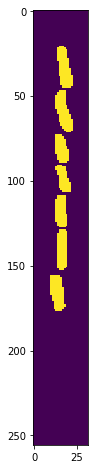

In [81]:
#check the masks look good
plt.imshow(image_pair_dict['mask'])

## Save images

In [64]:
image_dest_path = './training/data/'

mask_imgs = []
phase_imgs = []

for file, image_pair_dict in image_dict.items():
    mask_imgs.append(image_pair_dict['mask'])
    phase_imgs.append(image_pair_dict['phase'])
    
mask_imgs = np.stack(mask_imgs)
phase_imgs = np.stack(phase_imgs)

# increase axis of phase and mask by 1
mask_imgs = np.expand_dims(mask_imgs, -1)
phase_imgs = np.expand_dims(phase_imgs, -1)

with tiff.TiffWriter(os.path.join(image_dest_path, 'masks.tif'), imagej=False) as tif:
        tif.save(mask_imgs, photometric='minisblack')
        
with tiff.TiffWriter(os.path.join(image_dest_path, 'phase.tif'), imagej=False) as tif:
        tif.save(phase_imgs, photometric='minisblack')

## Load images if needed

In [36]:
#run this only if you are loading masks and images from a previous session

image_dest_path = './training_data_from_GUI/'

with tiff.TiffFile(os.path.join(image_dest_path, 'masks.tif')) as tif:
    mask_imgs = tif.asarray()
    
with tiff.TiffFile(os.path.join(image_dest_path, 'phase.tif')) as tif:
    phase_imgs = tif.asarray()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ryan/motherMachineSegger/training_data_from_GUI/masks.tif'

# Training the model

## Make generators

In [66]:
# we create two instances with the same arguments
train_data_gen_args = dict(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
rotation_range=2,
width_shift_range=0.05,
height_shift_range=0.05,
brightness_range=None, # this seems to mess up the training
shear_range=2, 
zoom_range=0.1,
horizontal_flip=True,
vertical_flip=True,
data_format='channels_last',
fill_mode='constant') # there is just one channel for grayscale

train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

# Everything defaults to False or None. 
val_data_gen_args = dict(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False) 

val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_data_gen_args)

In [67]:
seed = 1
batch_size = 5
target_size = (256, 32)
training_frac = 0.8 # 80% for training, rest for validation
training_frac_int = int(np.around(len(mask_imgs)*training_frac, 0))
print(training_frac_int)


42


In [68]:
phase_imgs[:training_frac_int].shape

(42, 256, 32, 1)

## We need to define this new generator because zip doesn't work
* See https://github.com/keras-team/keras/issues/13123

In [69]:
def new_generator(a,b): #a,b are image and mask generators
    while 'shiv'=='shiv':
        a1 = a.next()
        b1 = b.next()
        yield(a1, b1)

In [70]:
train_image_generator = train_image_datagen.flow(x=phase_imgs[:training_frac_int],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

train_mask_generator = train_mask_datagen.flow(x=mask_imgs[:training_frac_int],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

train_generator = new_generator(train_image_generator, train_mask_generator)

val_image_generator = train_image_datagen.flow(x=phase_imgs[training_frac_int:],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

val_mask_generator = train_mask_datagen.flow(x=mask_imgs[training_frac_int:],
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 seed=seed)

val_generator = new_generator(val_image_generator, val_mask_generator)

## Visualize augmented images

In [71]:
aug_output_path = './training/augmented/'

try:
    os.makedirs(aug_output_path)
except:
    print(aug_output_path, 'already exists.')

for i in range(50):

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4), squeeze=False)
    ax = axes.ravel()

    img = train_image_generator.next()[0,:,:,0]
    mask = train_mask_generator.next()[0,:,:,0]

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].imshow(mask, alpha=0.25, cmap=plt.cm.Greens)

    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    
    fig.tight_layout()

    with tiff.TiffWriter(os.path.join(aug_output_path, '{:02d}.tif'.format(i)), imagej=False) as tif:
        tif.save(img, photometric='minisblack', compress=5)
    
    plt.close()

/Users/ryan/growthlaw/20200805_sj1536/analysis/training_0915/augmented/ already exists.


# Build the model using keras
* This is where we set of the U-net architecture of the model.
* The size and complexity of the model increase with more layers. I have found the small model (16) to work fine, but there is a lot more optimization that could be done.

### Layer functions

In [72]:
# define what happens at each layer
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder


In [73]:
# make the layers
inputs = layers.Input(shape=(target_size[0], target_size[1], 1))
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
center = conv_block(encoder3_pool, 512) # we were using 128 before
# center
# 32
decoder3 = decoder_block(center, encoder3, 256)
# 64
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

# make the model
model = models.Model(inputs=[inputs], outputs=[outputs])

## Loss functions

In [74]:
def dice_coeff(y_true, y_pred):
    smooth = 0.01 # originally 1. Make sure this is float. 
    score_factor = 2. # originally 2. Same, keep as float. 
    # Flatten
    y_true_f = tf.reshape(y_true, [-1]) # flattens tensor
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f) # sums the resulting product
    score = (score_factor * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Compile the model and show us its structure

In [75]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 32, 1)   0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 32, 32)  320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_44 (Batc (None, 256, 32, 32)  128         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 256, 32, 32)  0           batch_normalization_v1_44[0][0]  
__________________________________________________________________________________________________
conv2d_39 

## Save the model and set what the readout will be while it is training

In [76]:
save_model_path = './models/20200916_MG1655_MOPS_sorbitol_256x32.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', 
                                        save_best_only=True, verbose=1)

## Train model

In [82]:
epochs = 200 # number of iterations

In [83]:
print(time.asctime(time.localtime()))

# note the numbers for the steps are the number of images imported 
history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(np.ceil(train_image_generator.n/float(batch_size))),
    epochs=epochs,
    callbacks=[cp],
    validation_data=val_generator,
    validation_steps=int(np.ceil(val_image_generator.n/float(batch_size))))

print(time.asctime(time.localtime()))

Wed Sep 16 17:54:34 2020
Epoch 1/200
3/3 [==============================] - 0s 85ms/step - loss: 0.7985 - dice_loss: 0.1359

Epoch 00001: val_dice_loss improved from 0.13592 to 0.13589, saving model to /Users/ryan/growthlaw/20200805_sj1536/models/20200916_MG1655_MOPS_sorbitol_256x32.hdf5
9/9 [==============================] - 5s 555ms/step - loss: 0.9457 - dice_loss: 0.1311 - val_loss: 0.7985 - val_dice_loss: 0.1359
Epoch 2/200
3/3 [==============================] - 0s 76ms/step - loss: 0.7894 - dice_loss: 0.1367

Epoch 00002: val_dice_loss did not improve from 0.13589
9/9 [==============================] - 4s 490ms/step - loss: 0.9412 - dice_loss: 0.1302 - val_loss: 0.7894 - val_dice_loss: 0.1367
Epoch 3/200
3/3 [==============================] - 0s 76ms/step - loss: 0.8007 - dice_loss: 0.1407

Epoch 00003: val_dice_loss did not improve from 0.13589
9/9 [==============================] - 5s 503ms/step - loss: 0.9186 - dice_loss: 0.1288 - val_loss: 0.8007 - val_dice_loss: 0.1407
Epoch 

Epoch 28/200
3/3 [==============================] - 0s 87ms/step - loss: 0.7870 - dice_loss: 0.1445

Epoch 00028: val_dice_loss did not improve from 0.13225
9/9 [==============================] - 5s 500ms/step - loss: 0.9212 - dice_loss: 0.1281 - val_loss: 0.7870 - val_dice_loss: 0.1445
Epoch 29/200
3/3 [==============================] - 0s 76ms/step - loss: 0.7907 - dice_loss: 0.1414

Epoch 00029: val_dice_loss did not improve from 0.13225
9/9 [==============================] - 4s 485ms/step - loss: 0.9060 - dice_loss: 0.1269 - val_loss: 0.7907 - val_dice_loss: 0.1414
Epoch 30/200
3/3 [==============================] - 1s 196ms/step - loss: 0.8211 - dice_loss: 0.1418

Epoch 00030: val_dice_loss did not improve from 0.13225
9/9 [==============================] - 5s 542ms/step - loss: 0.9156 - dice_loss: 0.1280 - val_loss: 0.8211 - val_dice_loss: 0.1418
Epoch 31/200
3/3 [==============================] - 0s 80ms/step - loss: 0.7990 - dice_loss: 0.1304

Epoch 00031: val_dice_loss improve

Epoch 56/200
3/3 [==============================] - 0s 76ms/step - loss: 0.8366 - dice_loss: 0.1465

Epoch 00056: val_dice_loss did not improve from 0.12945
9/9 [==============================] - 4s 485ms/step - loss: 0.8852 - dice_loss: 0.1228 - val_loss: 0.8366 - val_dice_loss: 0.1465
Epoch 57/200
3/3 [==============================] - 0s 76ms/step - loss: 0.7708 - dice_loss: 0.1315

Epoch 00057: val_dice_loss did not improve from 0.12945
9/9 [==============================] - 4s 496ms/step - loss: 0.8890 - dice_loss: 0.1237 - val_loss: 0.7708 - val_dice_loss: 0.1315
Epoch 58/200
3/3 [==============================] - 0s 79ms/step - loss: 0.8337 - dice_loss: 0.1369

Epoch 00058: val_dice_loss did not improve from 0.12945
9/9 [==============================] - 4s 482ms/step - loss: 0.9184 - dice_loss: 0.1264 - val_loss: 0.8337 - val_dice_loss: 0.1369
Epoch 59/200
3/3 [==============================] - 0s 77ms/step - loss: 0.8079 - dice_loss: 0.1325

Epoch 00059: val_dice_loss did not 

9/9 [==============================] - 5s 607ms/step - loss: 0.8536 - dice_loss: 0.1182 - val_loss: 0.7756 - val_dice_loss: 0.1284
Epoch 85/200
3/3 [==============================] - 0s 106ms/step - loss: 0.7786 - dice_loss: 0.1319

Epoch 00085: val_dice_loss did not improve from 0.12840
9/9 [==============================] - 5s 525ms/step - loss: 0.8600 - dice_loss: 0.1182 - val_loss: 0.7786 - val_dice_loss: 0.1319
Epoch 86/200
3/3 [==============================] - 0s 81ms/step - loss: 0.7898 - dice_loss: 0.1369

Epoch 00086: val_dice_loss did not improve from 0.12840
9/9 [==============================] - 5s 527ms/step - loss: 0.8493 - dice_loss: 0.1175 - val_loss: 0.7898 - val_dice_loss: 0.1369
Epoch 87/200
3/3 [==============================] - 0s 82ms/step - loss: 0.7607 - dice_loss: 0.1251

Epoch 00087: val_dice_loss improved from 0.12840 to 0.12507, saving model to /Users/ryan/growthlaw/20200805_sj1536/models/20200916_MG1655_MOPS_sorbitol_256x32.hdf5
9/9 [======================

Epoch 113/200
3/3 [==============================] - 0s 79ms/step - loss: 0.8034 - dice_loss: 0.1357

Epoch 00113: val_dice_loss did not improve from 0.12507
9/9 [==============================] - 5s 506ms/step - loss: 0.8334 - dice_loss: 0.1146 - val_loss: 0.8034 - val_dice_loss: 0.1357
Epoch 114/200
3/3 [==============================] - 0s 79ms/step - loss: 0.7979 - dice_loss: 0.1445

Epoch 00114: val_dice_loss did not improve from 0.12507
9/9 [==============================] - 5s 522ms/step - loss: 0.8418 - dice_loss: 0.1158 - val_loss: 0.7979 - val_dice_loss: 0.1445
Epoch 115/200
3/3 [==============================] - 0s 81ms/step - loss: 0.8209 - dice_loss: 0.1438

Epoch 00115: val_dice_loss did not improve from 0.12507
9/9 [==============================] - 5s 512ms/step - loss: 0.8320 - dice_loss: 0.1155 - val_loss: 0.8209 - val_dice_loss: 0.1438
Epoch 116/200
3/3 [==============================] - 0s 83ms/step - loss: 0.8155 - dice_loss: 0.1412

Epoch 00116: val_dice_loss did 


Epoch 00141: val_dice_loss did not improve from 0.12507
9/9 [==============================] - 5s 551ms/step - loss: 0.8170 - dice_loss: 0.1127 - val_loss: 0.8114 - val_dice_loss: 0.1455
Epoch 142/200
3/3 [==============================] - 0s 86ms/step - loss: 0.7683 - dice_loss: 0.1284

Epoch 00142: val_dice_loss did not improve from 0.12507
9/9 [==============================] - 5s 511ms/step - loss: 0.8071 - dice_loss: 0.1115 - val_loss: 0.7683 - val_dice_loss: 0.1284
Epoch 143/200
3/3 [==============================] - 0s 82ms/step - loss: 0.7916 - dice_loss: 0.1290

Epoch 00143: val_dice_loss did not improve from 0.12507
9/9 [==============================] - 5s 525ms/step - loss: 0.8031 - dice_loss: 0.1098 - val_loss: 0.7916 - val_dice_loss: 0.1290
Epoch 144/200
3/3 [==============================] - 0s 88ms/step - loss: 0.7899 - dice_loss: 0.1275

Epoch 00144: val_dice_loss did not improve from 0.12507
9/9 [==============================] - 5s 527ms/step - loss: 0.7945 - dice_l

Epoch 198/200
3/3 [==============================] - 0s 85ms/step - loss: 0.8274 - dice_loss: 0.1339

Epoch 00198: val_dice_loss did not improve from 0.12471
9/9 [==============================] - 5s 537ms/step - loss: 0.7530 - dice_loss: 0.1038 - val_loss: 0.8274 - val_dice_loss: 0.1339
Epoch 199/200
3/3 [==============================] - 0s 82ms/step - loss: 0.8125 - dice_loss: 0.1305

Epoch 00199: val_dice_loss did not improve from 0.12471
9/9 [==============================] - 5s 523ms/step - loss: 0.7179 - dice_loss: 0.1000 - val_loss: 0.8125 - val_dice_loss: 0.1305
Epoch 200/200
3/3 [==============================] - 0s 80ms/step - loss: 0.8084 - dice_loss: 0.1327

Epoch 00200: val_dice_loss did not improve from 0.12471
9/9 [==============================] - 5s 515ms/step - loss: 0.7275 - dice_loss: 0.1000 - val_loss: 0.8084 - val_dice_loss: 0.1327
Wed Sep 16 18:10:19 2020


## Visualize fit

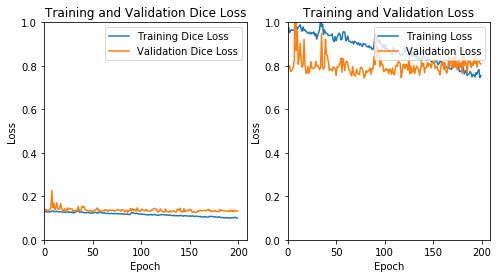

In [85]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, None)
plt.ylim(0,1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, None)
plt.ylim(0,1)


plt.savefig('./training/training_result.pdf', dpi=200)
plt.show()
plt.close()

## Test predictions

In [25]:
image_output_path = './training/test_output'

try:
    os.makedirs(image_output_path)
except:
    print(image_output_path, 'already exists.')

In [28]:
# for the validation data we do no augmentation
test_image_datagen = ImageDataGenerator()
test_image_generator = test_image_datagen.flow(x=phase_imgs,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 seed=seed)

In [29]:
predictions = model.predict_generator(test_image_generator, verbose=1)

59/59 [==============================] - 3s 46ms/step


In [34]:
test_image_generator.reset() # start generator over
n_imgs = predictions.shape[0]
for i in range(n_imgs):

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1/2, target_size[0]/target_size[1]/2), squeeze=False)
    ax = axes.ravel()

    img = test_image_generator.next()[0,:,:,0]
    predicted_label = np.copy(predictions[i,:,:,0])
#     predicted_label[predicted_label >= 0.2] = 1
#     predicted_label[predicted_label < 0.2] = 0

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].imshow(predicted_label, alpha=0.25, cmap=plt.cm.Greens)

    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
    fig.savefig(os.path.join(image_output_path, '{:02d}.png'.format(i)), dpi=200)

#     predicted_label = np.around(predicted_label * 100).astype('uint8')
#     with tiff.TiffWriter(os.path.join(image_output_path, '{:02d}.tif'.format(i)), imagej=False) as tif:
#         tif.save(predicted_label, photometric='minisblack', compress=5)
    
#     fig.show()
    plt.close()

In [32]:
target_size[0]/target_size[1]

8.0